# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


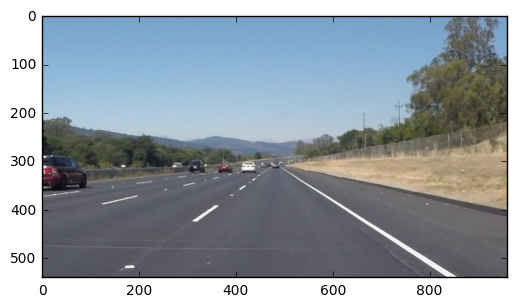

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_no_interest(img, vertices_out):
    """
    Applies an image mask to filter out the region enclosed in the polygon formed
    by `vertices_out`.    
    """
    #defining a blank mask to start with
    mask = np.ones_like(img)*255
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        mask_color = (0,) * channel_count
    else:
        mask_color = 0
        
    #filling pixels inside the polygon defined by `vertices_out` with the mask color
    cv2.fillPoly(mask, vertices_out, mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def region_of_interest(img, vertices_in):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the region inside
    the polygon formed from `vertices_in` and outside the polygon formed from
    `vertices_out`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255    
    
    #filling pixels inside the polygon defined by `vertices_in` with the fill color
    cv2.fillPoly(mask, vertices_in, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2,
               left_slopes=None, right_slopes=None, 
               left_bounds=None, right_bounds=None,
               left_lengths=None, right_lengths=None):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # find the slope and intercept of the longest left lane and right lanes
    left_lane_slope = 0
    left_lane_intercept = 0
    right_lane_slope = 0
    right_lane_intercept = 0
    left_lane_length = 0
    right_lane_length = 0
    
    left_lane_slopes = []
    left_lane_intercepts = []
    left_lane_lengths = []
    right_lane_slopes = []
    right_lane_intercepts = []
    right_lane_lengths = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            # find the length and slope of the line
            length = math.sqrt((x2-x1)**2+(y2-y1)**2)
            m = (y2-y1)/(x2-x1)
            
            # we limit the slope of the left lane to be between -0.82 and -0.60            
            if m > -0.82 and m < -0.60:
                b = y1-m*x1
                left_lane_slopes.append(m)
                left_lane_intercepts.append(b)
                left_lane_lengths.append(length)
            
            # we limit the slope of the right lane to be between 0.49 and 0.71
            if m > 0.49 and m < 0.71:
                b = y1-m*x1
                right_lane_slopes.append(m)
                right_lane_intercepts.append(b)
                right_lane_lengths.append(length)
                
    # find the two longest line segments on the left and 
    # take the average of their slope and intercept
    left_ind = np.argpartition(np.array(left_lane_lengths), len(left_lane_lengths)-2)[-2:]
    if left_ind.size > 0:
        left_lane_slope = np.average(np.array(left_lane_slopes)[left_ind])
        left_lane_intercept = np.average(np.array(left_lane_intercepts)[left_ind])
        left_lane_length = np.average(np.array(left_lane_lengths)[left_ind])
    
    # use previous 10 or less frames to average out the slope and intercept
    if left_lengths:
        n = min(10, len(left_lengths))
        weights = left_lengths[-n:]/np.array(range(n,0,-1))
        left_lane_slope = (left_lane_slope*left_lane_length+
                           np.sum(left_slopes[-n:]*weights)) / (left_lane_length+np.sum(weights))
        prev_intercepts = img.shape[0] - img.shape[1]*np.array(left_bounds[-n:])*np.array(left_slopes[-n:])
        left_lane_intercept = (left_lane_intercept*left_lane_length+
                               np.sum(prev_intercepts*weights)) / (left_lane_length+np.sum(weights))
    sx = 0
    sy = int(left_lane_slope*sx+left_lane_intercept)
    tx = img.shape[1]
    ty = int(left_lane_slope*tx+left_lane_intercept)
    
    # draw the left lane line
    cv2.line(img, (sx, sy), (tx, ty), color, thickness)
    if left_ind.size > 0:
        if left_slopes is not None:
            left_slopes.append(left_lane_slope)
        if left_bounds is not None:
            left_bounds.append((img.shape[0]-left_lane_intercept)/left_lane_slope/img.shape[1])
        if left_lengths is not None:
            left_lengths.append(np.average(np.array(left_lane_lengths)[left_ind]))
    
    # find the two longest line segments on the right and 
    # take the average of their slope and intercept
    right_ind = np.argpartition(np.array(right_lane_lengths), len(right_lane_lengths)-2)[-2:]
    if right_ind.size > 0:
        right_lane_slope = np.average(np.array(right_lane_slopes)[right_ind])
        right_lane_intercept = np.average(np.array(right_lane_intercepts)[right_ind])
        right_lane_length = np.average(np.array(right_lane_lengths)[right_ind])

    # use previous 10 or less frames to average out the slope and intercept
    if right_lengths:
        n = min(10, len(right_lengths))
        weights = right_lengths[-n:]/np.array(range(n,0,-1))
        right_lane_slope = (right_lane_slope*right_lane_length+
                            np.sum(right_slopes[-n:]*weights)) / (right_lane_length+np.sum(weights))
        prev_intercepts = img.shape[0] - img.shape[1]*np.array(right_bounds[-n:])*np.array(right_slopes[-n:])
        right_lane_intercept = (right_lane_intercept*right_lane_length+
                                np.sum(prev_intercepts*weights)) / (right_lane_length+np.sum(weights))    
    sx = 0
    sy = int(right_lane_slope*sx+right_lane_intercept)
    tx = img.shape[1]
    ty = int(right_lane_slope*tx+right_lane_intercept)
    
    # draw the right lane line
    cv2.line(img, (sx, sy), (tx, ty), color, thickness)
    if right_ind.size > 0:
        if right_slopes is not None:
            right_slopes.append(right_lane_slope)
        if right_bounds is not None:
            right_bounds.append((img.shape[0]-right_lane_intercept)/right_lane_slope/img.shape[1])
        if right_lengths is not None:
            right_lengths.append(np.average(np.array(right_lane_lengths)[right_ind]))
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, 
                left_slopes, right_slopes, left_bounds, right_bounds, left_lengths, right_lengths):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, 
                            maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=5, 
               left_slopes=left_slopes, right_slopes=right_slopes, 
               left_bounds=left_bounds, right_bounds=right_bounds,
               left_lengths=left_lengths, right_lengths=right_lengths)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.5, β=1.5, λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg']

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


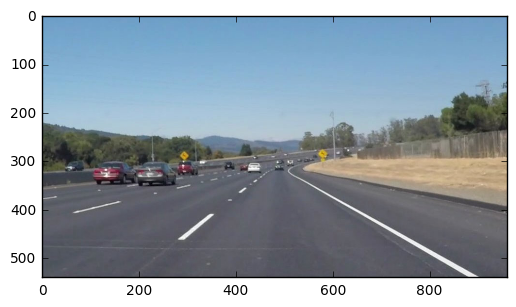

In [5]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [6]:
def process_image(image, left_slopes=None, right_slopes=None, 
                  left_bounds=None, right_bounds=None, 
                  left_lengths=None, right_lengths=None):
    """ Lane detection pipeline for static images
    """
    # Convert image to grayscale
    gray_image = grayscale(image)
    
    # Apply Gaussian blur to reduce noise
    denoised_image = gaussian_blur(gray_image, 5)
    
    # Apply Canny edge detection
    low_threshold = 50
    high_threshold = 150
    edge = canny(denoised_image, low_threshold, high_threshold)
    
    # Find region of interest
    image_height = image.shape[0]
    image_width = image.shape[1]
    # Filter in a triangular region enclosing the lower part of the lane lines
    apex1 = (np.int32(image_width/2), np.int32(image_height/2))
    lower_left_vertex1 = (math.floor(0.14*image_width), image_height)
    lower_right_vertex1 = (math.ceil(0.93*image_width), image_height)
    vertices1 = np.array([[lower_left_vertex1,
                           apex1,
                           apex1, 
                           lower_right_vertex1]], dtype=np.int32)
    masked_edge1 = region_of_interest(edge, vertices1)
    
    # Filter out a triangular region inside the lanes
    lower_left_vertex2 = (math.ceil(0.21*image_width), image_height)
    lower_right_vertex2 = (math.floor(0.86*image_width), image_height)    
    apex2 = (apex1[0], apex1[1]*1.15)        
    vertices2 = np.array([[lower_left_vertex2,
                           apex2,
                           apex2,
                           lower_right_vertex2]], dtype=np.int32)
    masked_edge2 = region_of_no_interest(masked_edge1, vertices2)
    
    # Filter out the top two thirds of the image
    box_height = 2/3*image_height
    vertices3 = np.array([[(0,0), (0,box_height), (image_width,box_height), (image_width,0)]], 
                         dtype=np.int32)
    masked_edge3 = region_of_no_interest(masked_edge2, vertices3)

    # Apply Hough transformation to detect lanes
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_len = 10
    max_line_gap = 20 
    lanes = hough_lines(masked_edge3, rho, theta, threshold, min_line_len, max_line_gap,
                        left_slopes, right_slopes, left_bounds, right_bounds,
                        left_lengths, right_lengths)

    # Apply mask once again to mask over excess in colored lane lines
    vertices4 = np.array([[(0, image_height), 
                           (0, apex1[1]*1.2), 
                           (image_width, apex1[1]*1.2), 
                           (image_width, image_height)]], 
                         dtype=np.int32)
    masked_lanes = region_of_interest(lanes, vertices4)
    
    # Overlay the original image
    result = weighted_img(masked_lanes, image, α=0.8, β=3)
    return result

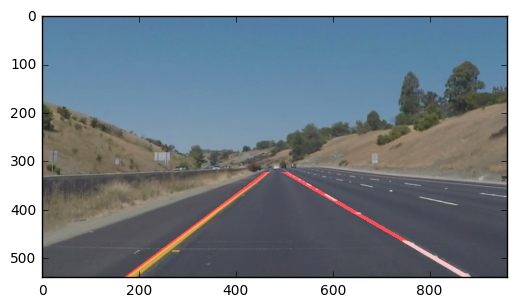

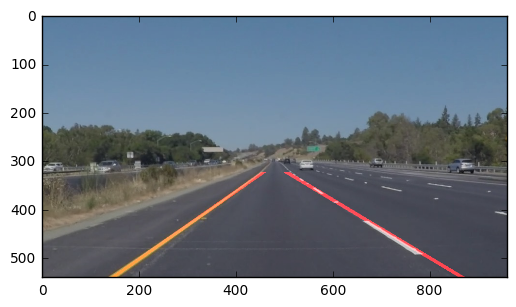

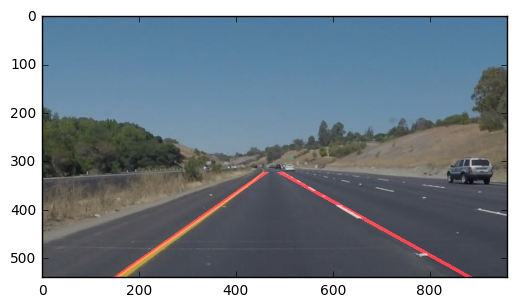

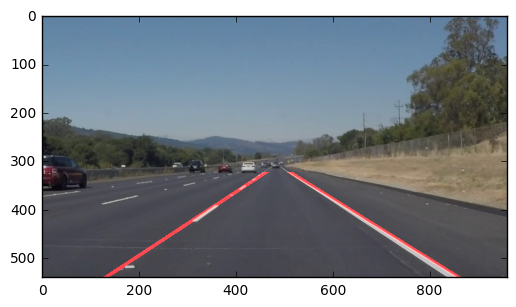

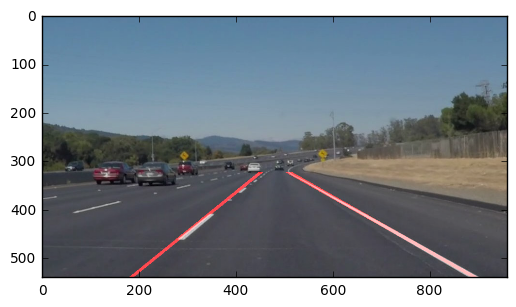

In [7]:
# Test on the five static images

from pathlib import Path
p = Path('test_images')
images = []
images_post_lane_detection = []
    
# Gather data on slopes and intercepts of the lines
for file in p.iterdir():
    image = mpimg.imread(file)
    images.append(image)
    images_post_lane_detection.append(process_image(image))

for i in range(5):
    plt.figure()
    plt.imshow(images_post_lane_detection[i])

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [9]:
import functools
# Gather data on slopes and intercepts of the lines
left_slopes = []
right_slopes = []
left_bounds = []
right_bounds = []
left_lengths = []
right_lengths = []

process_image_gather_data = functools.partial(process_image, left_slopes=left_slopes,
                                              right_slopes=right_slopes,
                                              left_bounds=left_bounds,
                                              right_bounds=right_bounds,
                                              left_lengths=left_lengths,
                                              right_lengths=right_lengths)

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_gather_data) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 40.24it/s]     | 4/222 [00:00<00:06, 32.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 25.3 s, sys: 164 ms, total: 25.4 s
Wall time: 5.82 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
# Gather data on slopes and intercepts of the lines
left_slopes = []
right_slopes = []
left_bounds = []
right_bounds = []
left_lengths = []
right_lengths = []

process_image_gather_data = functools.partial(process_image, left_slopes=left_slopes,
                                              right_slopes=right_slopes,
                                              left_bounds=left_bounds,
                                              right_bounds=right_bounds,
                                              left_lengths=left_lengths,
                                              right_lengths=right_lengths)

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_gather_data)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:16<00:00, 40.39it/s]     | 5/682 [00:00<00:16, 42.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 19s, sys: 640 ms, total: 1min 19s
Wall time: 17.2 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


**Overview of the pipeline**

First allow me to describe the lane detection pipeline in `process_image`:

1. Convert image to grayscale
2. Apply Gaussian blur to reduce noise
3. Apply Canny edge detection to detect edges in the image
4. Mask all region outside the region of interest
</br>
<figure>
 <img src="masked_region.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align:center;font-size:10px"> How the image looks after applying a mask to blacken the pixels outside the region of interest. <br> In the actual pipeline, the mask is applied on the result of the Canny edge detection.</p> 
 </figcaption>
</figure>
</br>
5. Apply Hough transform to detect lanes (more on this later)
6. Apply another mask to trim excess from the lanes drawn
7. Overlay the lanes on the original image

** The `draw_lines` algorithm **

The `draw_lines` function contains the heart of the algorithm for choosing where exactly to draw the lane lines. The approach we take is to determine a *slope* and an *intercept* to represent each of the left and right lane lines. To do so, we applied the following ideas:
- Given our end goal is to detect lanes in videos (and not a static images), and the lane lines from frame to frame do not vary significant under almost all scenarios, it makes sense to apply a 'temporal smoothing' to calibrate the slopes and intercepts in the current frame based on those from previous frames.
- We filter the segments determined from the Hough Line Transform based on their slopes. For the left lane, we only consider segments with slope between -0.82 and -0.60; for the right lane, we only consider segments with slope between 0.49 and 0.71. These bounds are chosen through an iterative trial-and-error process (not unlikely reducing an error function in machine learning): Each iteration we collect the slopes and intercepts of all line segments that lie within the bounds, calculate the mean and standard deviation, then update the bound to be about one standard deviation around the mean.
- From the lines that lie within the bounds, we choose the two longest lines, take the average of their slopes and intercepts, then apply the 'temporal smoothing' mentioned earlier.

** Room for improvement **

Here are some obvious improvements I can and like to make:

1. The algorithm models lane lines as straight line segments, thus cannot properly detect lanes with sharp bends.
2. The algorithm depends on the Canny edge detection algorithm, and our application of this algorithm has fixed thresholds. This means the algorithm is very sensitive to the quality of the video and the cleanliness of the lane lines in the footage. If the video has poor lightening, low contrast, or some other suboptimal aspects, then the algorithm may not work.
3. Similar to issue 2, I used fixed parameters in numerous places, such as the bounds on the slope. It may make sense to choose these parameters dynamically based on the video processed so far.
4. The algorithm does not handle lane changes, at least not the transition phase.
5. From a software engineering perspective, the pipeline can use
    - more testing on more video footages
    - less-smelly code, modularization, single-purpose functions, and other good coding practices can help
    - improvements on performance and efficiency
    - improvements on extensibility
    
I hope to continue to make these improvements.

By the way, I also apply the algorithm above on the Optional Challenge. Please see the video at the end.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
# Gather data on slopes and intercepts of the lines
left_slopes = []
right_slopes = []
left_bounds = []
right_bounds = []
left_lengths = []
right_lengths = []

process_image_gather_data = functools.partial(process_image, left_slopes=left_slopes,
                                              right_slopes=right_slopes,
                                              left_bounds=left_bounds,
                                              right_bounds=right_bounds,
                                              left_lengths=left_lengths,
                                              right_lengths=right_lengths)

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image_gather_data)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:08<00:00, 30.79it/s]     | 5/251 [00:00<00:05, 41.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 33.4 s, sys: 452 ms, total: 33.9 s
Wall time: 8.79 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))